In [20]:
from run_dnerf import config_parser, create_nerf
import matplotlib.pyplot as plt
import torch
from load_blender import pose_spherical
from run_dnerf import render_path
from run_dnerf_helpers import to8b

# set cuda
torch.set_default_tensor_type('torch.cuda.FloatTensor')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get config file
config_file = "configs/watercube.txt"
parser = config_parser()
args = parser.parse_args(f'--config {config_file}')

# set render params
hwf = [200, 200, 612.932]
_, render_kwargs_test, _, _, _ = create_nerf(args)
render_kwargs_test.update({'near' : 9., 'far' : 13.})

def generate_img(time, azimuth, elevation, radius):
    assert 0. <= time <= 1.
    assert -180 <= azimuth <= 180
    assert -180 <= elevation <= 180
    
    render_poses = torch.unsqueeze(pose_spherical(azimuth, elevation, radius), 0).to(device)
    render_poses = torch.tensor([[[ -0.9238795042037964, -0.1667598932981491, 0.3444383144378662, 3.7061424255371094 ],
                [ 0.3826834559440613, -0.4025939702987671, 0.8315476179122925, 8.947419166564941 ],
                [ 0.0, 0.9000606536865234, 0.4357646107673645, 4.688809871673584 ],
                [ .0, 0.0, 0.0, 1.0 ]]]).to(device)
    # print('azimuth =',azimuth,' elevation =',elevation,' radius =',radius)
    # print('render_poses:',render_poses)
    render_times = torch.Tensor([time]).to(device)

    with torch.no_grad():
            rgbs, _ = render_path(render_poses, render_times, hwf, args.chunk, render_kwargs_test, render_factor=args.render_factor)
    rgbs = to8b(rgbs)
    return rgbs[0]

NeRF type selected: direct_temporal
Found ckpts ['logs/watercube6/100000.tar', 'logs/watercube6/200000.tar', 'logs/watercube6/300000.tar', 'logs/watercube6/400000.tar', 'logs/watercube6/500000.tar', 'logs/watercube6/600000.tar', 'logs/watercube6/700000.tar', 'logs/watercube6/800000.tar']
Reloading from logs/watercube6/800000.tar


100%|██████████| 1/1 [00:01<00:00,  1.23s/it]


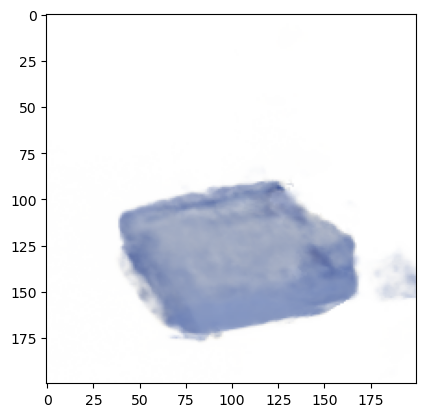

In [22]:
img = generate_img(0, 0, 0, 0)
plt.imshow(img)

In [16]:
import math
import numpy as np
initial_x = 8.58488
initial_y = -4.48237
initial_z = 4.68881
rxy = math.sqrt(initial_x ** 2 + initial_y ** 2)
radius = math.sqrt(initial_x ** 2 + initial_y ** 2 + initial_z ** 2)
elevation = -math.atan2(initial_z,rxy)*180./np.pi  # 仰角,in [-180,180]
print(radius)

10.759960253058559


100%|██████████| 1/1 [00:01<00:00,  1.24s/it]


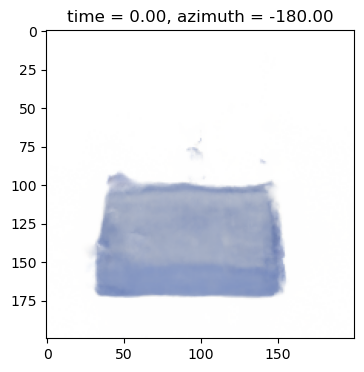

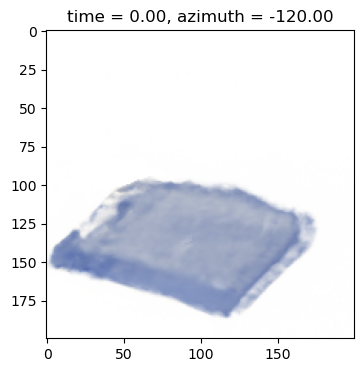

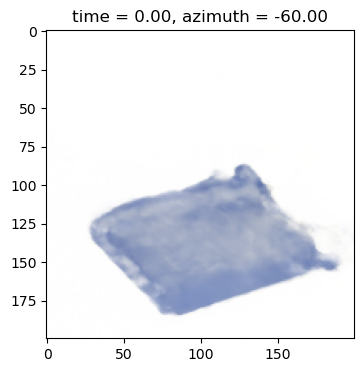

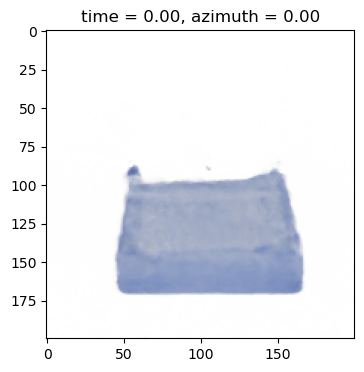

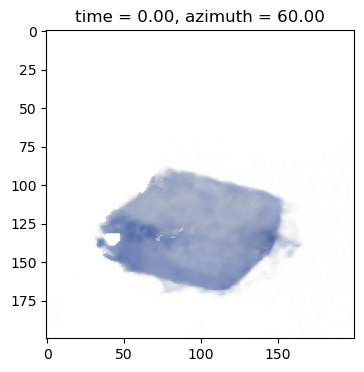

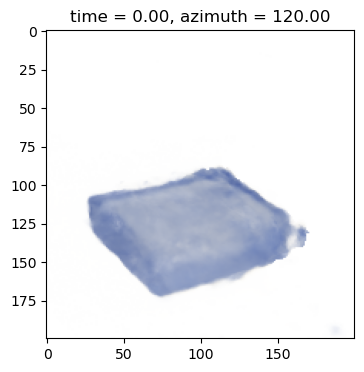

In [18]:
# genearte
time = .8  # in [0,1]
azimuth = 120  # 方位角,in [-180,180]
import os
save_dir = 'novel view/'+args.expname+'/'
# for time in np.linspace(0, 1, 5):
for time in [0]:
    os.makedirs(save_dir+f'{time:.2f}', exist_ok=True)
    for azimuth in range (-180, 180, 60):
        img = generate_img(time, azimuth, elevation, radius)
        # display
        plt.figure(figsize=(4,4))
        plt.title(f'time = {time:.2f}, azimuth = {azimuth:.2f}')
        plt.imshow(img)
        # plt.savefig(save_dir+f'{time:.2f}/azimuth={azimuth:.2f}.png')
        #plt.show()


In [ ]:
import os
from PIL import Image

def combine_images(images, direction):

    width, height = images[0].size
    width *= len(images)
    
    if direction == "vertical":
        height *= len(images)
        combined = Image.new('RGB', (width, height))
        y_offset = 0
        for img in images:
            combined.paste(img, (0, y_offset))
            y_offset += img.height

    elif direction == "horizontal":
        width *= len(images)
        combined = Image.new('RGB', (width, height))
        x_offset = 0
        for img in images:
            combined.paste(img, (x_offset, 0))
            x_offset += img.width

    combined = combined.crop(combined.getbbox())
    return combined

for time in np.linspace(0, 1, 5):
    path = save_dir+f'{time:.2f}'
    files = ['azimuth=-180.00.png','azimuth=-120.00.png','azimuth=-60.00.png',
    'azimuth=0.00.png','azimuth=60.00.png','azimuth=120.00.png']
    images = []
    for file_ in files:
        img = Image.open(os.path.join(path,file_))
        images.append(img)
    combined = combine_images(images, "horizontal")
    combined.save(save_dir+f'time={time:.2f}.png', quality=100)

files = [f for f in os.listdir(save_dir) if f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg')]
files.sort()
images = []
for file_ in files:
    img = Image.open(os.path.join(save_dir,file_))
    images.append(img)
combined = combine_images(images, "vertical")
combined.save(save_dir+f'all.png', quality=100)
print("Done!")

Done!
